In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict apple ("Close") returns with *lagged* apple returns. 

In [17]:
# Futures contract on the apple price:

apple = pd.read_csv(
    Path("apple.csv"), index_col="Date",parse_dates=True
)
apple.head()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-13,275.15,33432810,271.46,275.30,270.93
2019-12-12,271.46,34437040,267.78,272.56,267.32
2019-12-11,270.77,19723390,268.81,271.10,268.50
2019-12-10,268.48,22632380,268.60,270.07,265.86
2019-12-09,266.92,32182650,270.00,270.80,264.91


In [18]:
# Trim the dataset to begin on December 15, 2014
apple = apple.loc[: "2014-12-15"]
apple.head()

,Close,Volume,Open,High,Low
Date,,,,,
2019-12-13,275.15,33432810,271.46,275.30,270.93
2019-12-12,271.46,34437040,267.78,272.56,267.32
2019-12-11,270.77,19723390,268.81,271.10,268.50
2019-12-10,268.48,22632380,268.60,270.07,265.86
2019-12-09,266.92,32182650,270.00,270.80,264.91


# Data Preparation

### Returns

In [19]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
apple['Return'] = apple.Close.pct_change() * 100
apple = apple.replace(-np.inf, np.nan).dropna()
apple=apple.replace('$', '')
apple.tail()

,Close,Volume,Open,High,Low,Return
Date,,,,,,
2014-12-19,111.78,86595830,112.26,113.24,111.66,-1.027094
2014-12-18,112.65,58785590,111.87,112.65,110.66,0.778315
2014-12-17,109.41,53265930,107.12,109.84,106.82,-2.876165
2014-12-16,106.75,60651790,106.37,110.16,106.26,-2.431222
2014-12-15,108.23,67083260,110.70,111.60,106.35,1.386417


### Lagged Returns 

In [20]:
# Create a lagged return using the shift function
apple['Lagged_Return'] = apple.Return.shift()
apple = apple.replace(-np.inf, np.nan).dropna()
apple.tail()

,Close,Volume,Open,High,Low,Return,Lagged_Return
Date,,,,,,,
2014-12-19,111.78,86595830,112.26,113.24,111.66,-1.027094,0.355429
2014-12-18,112.65,58785590,111.87,112.65,110.66,0.778315,-1.027094
2014-12-17,109.41,53265930,107.12,109.84,106.82,-2.876165,0.778315
2014-12-16,106.75,60651790,106.37,110.16,106.26,-2.431222,-2.876165
2014-12-15,108.23,67083260,110.70,111.60,106.35,1.386417,-2.431222


### Train Test Split

In [21]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = apple[:'2018']
test = apple['2018':]


In [22]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [23]:
X_train.head()

,Lagged_Return
Date,
2019-12-11,-1.341087
2019-12-10,-0.254181
2019-12-09,-0.845736
2019-12-06,-0.581049
2019-12-05,1.419901


# Linear Regression Model

In [24]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [25]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [26]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AEA5AF8278>,
      dtype=object)

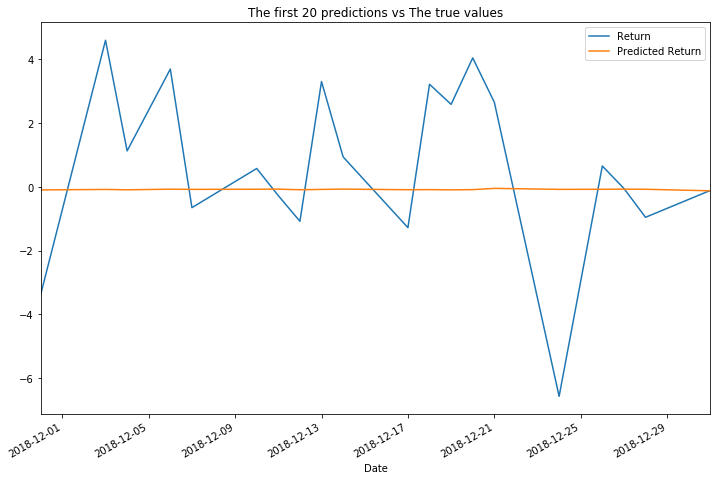

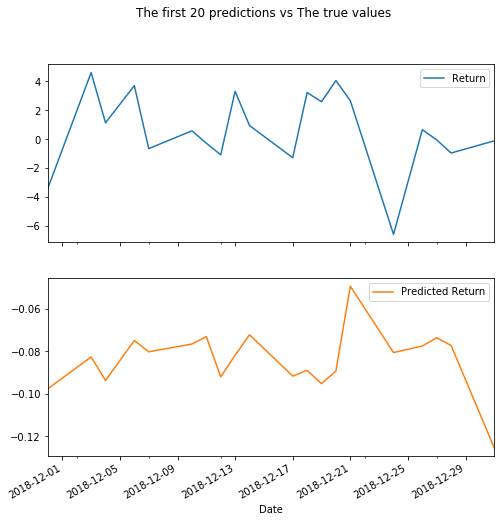

In [27]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [28]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 1.5442666296915482


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [29]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.762665072427249


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 